# 毕业项目-驾驶员状态检测

本项目是State Farm公司在Kaggle上发起的一个[竞赛项目](https://www.kaggle.com/c/state-farm-distracted-driver-detection)，目的是得到一个模型，用来检测司机在驾驶过程中是否走神。

该项目要求输入为一张2D彩色图片，输出为10种驾驶状态的概率。10种驾驶状态分别为：
- c0：安全驾驶
- c1：右手打字
- c2：右手打电话
- c3：左手打字
- c4：左手打电话
- c5：调收音机
- c6：喝饮料
- c7：拿后面的东西
- c8：整理头发和化妆
- c9：和其他乘客说话

数据集可以从[Kaggle](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)上下载。

## 加载和准备数据

先检查本地是否有数据，如果没有则抛出错误提示。如果有，查看数据集的基本信息。

数据名分别为：
- driver_imgs_list.csv.zip
- imgs.zip
- sample_submission.csv.zip

In [13]:
import os
import glob
import cv2
import pickle
import time
from os.path import isfile, isdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss
from zipfile import ZipFile

%matplotlib inline

In [2]:
# color_type = 0 - gray
# color_type = 1 - RGB
color_type_global = 0
random_state_global = 2018

# 标签独热编码
encode = LabelBinarizer()
encode.fit(['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg


Training set images numbers: 22424


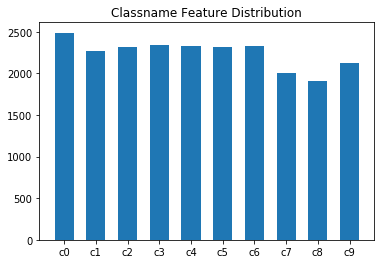

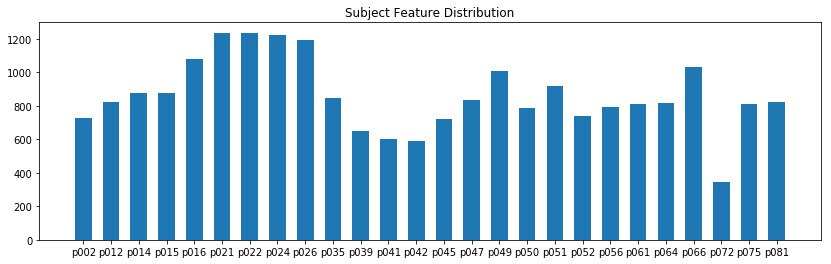

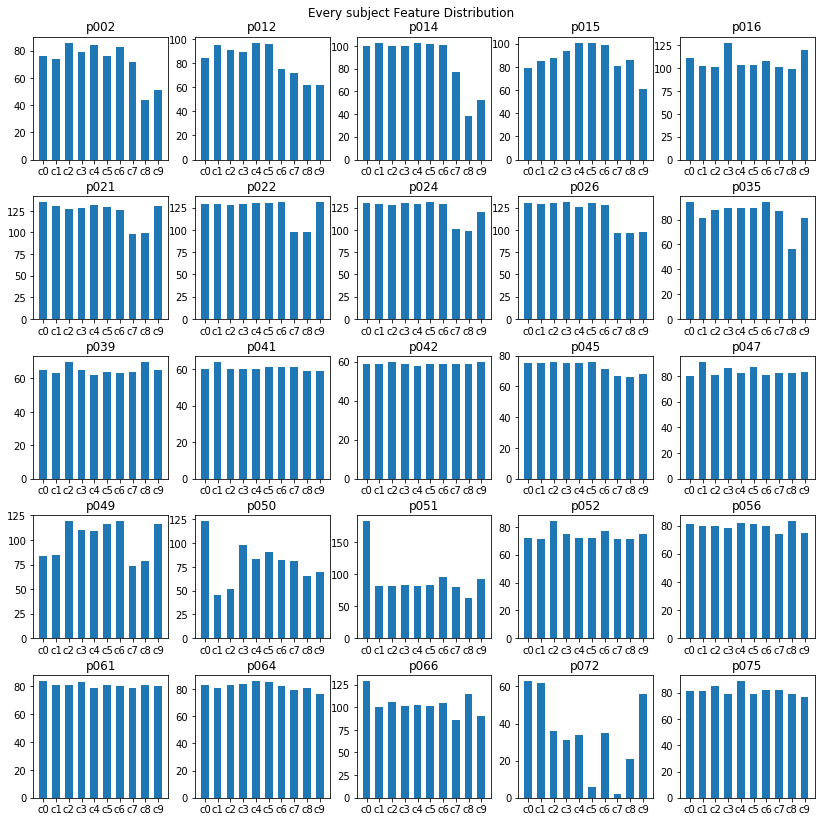

In [3]:
# 检查所需文件是否正确下载
assert isfile('imgs.zip'), "No files: imgs.zip"
assert isfile('driver_imgs_list.csv.zip'), "No files: driver_imgs_list.csv.zip" 
    
# 导入训练集的数据对应关系列表，显示前三条记录
with ZipFile('driver_imgs_list.csv.zip', 'r') as zipf:
    data = pd.read_csv(zipf.namelist()[0])
    display(data.head(n=3))
    print("Training set images numbers: {}".format(data.shape[0]))
    
    # 查看训练集中的行为类别分布,classname
    data_class = data['classname'].value_counts().sort_index(axis=0) # 获得classname对应的数量，按照c0-c9排序（pd.series）
    plt.figure(figsize=(6,4))
    plt.bar(list(data_class.index), data_class, width=0.6)
    plt.title("Classname Feature Distribution")

    
    # 查看训练集中的驾驶员分布，subject
    data_subject = data['subject'].value_counts().sort_index(axis=0)
    plt.figure(figsize=(14,4))
    plt.bar(list(data_subject.index), data_subject, width=0.6)
    plt.title("Subject Feature Distribution")

    # 查看每个驾驶员的行为类别分布
    list_subject = list(data_subject.index)
    fig = plt.figure(figsize=(14,14))
    fig.suptitle("Every subject Feature Distribution", y=0.91)
    plt.subplots_adjust(hspace=0.3)
    for i,subject in enumerate(list_subject[:-1]):
        ax = fig.add_subplot(5, 5, i+1)
        values = data[data.subject==subject]['classname'].value_counts().sort_index(axis=0)
        names = list(values.index)
        ax.bar(names, values, width=0.6)
        ax.set_title("{}".format(subject))

    plt.show()

# data：driver_classname_img的对应关系，DataFrame
# data_class：classname为index的序列，Series
# data_subject：driver为index的序列，Series
# list_subject：driver的列表

上面导入了训练集的驾驶员-图片对应关系表，表中分为3列。
- subject：代表驾驶员的代号。
- classname：代表对应的驾驶状态，取值为c0~c9。
- img：代表对应的图片名。

训练集数据共**22424**个，驾驶员共26位，训练集中c0-c9数据量分布比较均衡，多数驾驶员的状态分类也比较均衡。为了能更好的泛化，训练集和验证集可以按照驾驶员ID进行分割。

the image size is: 640 * 480


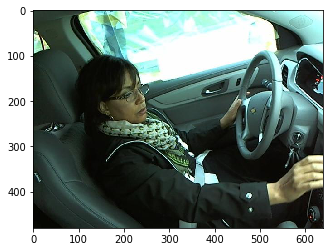

In [4]:
# 导入数据集中的一张图片，显示其尺寸信息
with ZipFile('imgs.zip', 'r') as zipf:
    img_sample = Image.open(zipf.open(zipf.namelist()[1]))
    plt.imshow(np.asarray(img_sample))

    width, height = img_sample.size
    print("the image size is: {} * {}".format(width, height))

### 解压数据集
将数据集解压，并且根据驾驶员id分割训练集和验证集。

In [5]:
# 解压数据集的代码

if not isdir('imgs'):
    with ZipFile('imgs.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(),desc='Extract files', unit='files'):
            zipf.extract(name,path='imgs')
     #   zipf.extractall(path='imgs',members=zipf.namelist()[:10000])
        zipf.close()

print("All files extracted")


All files extracted


In [94]:
## 用 subject 作交叉验证
print(list_subject)
print(len(list_subject))

test=data[data.subject=='p015']

display(test.head(n=4))

print(type(test))

list(test[0:1]['classname'])

['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
26


,subject,classname,img
2424,p015,c0,img_48693.jpg
2425,p015,c0,img_44903.jpg
2426,p015,c0,img_58514.jpg
2427,p015,c0,img_62307.jpg


<class 'pandas.core.frame.DataFrame'>


['c0']

In [47]:
data_path = "imgs/train/{}/{}".format('c0', 'img_48693.jpg')
image = cv2.imread(data_path, 0)
print(image)

print('-'*50)
image2 = cv2.imread(data_path, 1)
print(image2)

[[ 41  35  38 ..., 235 246 247]
 [ 43  44  45 ..., 239 248 251]
 [ 33  45  49 ..., 243 249 253]
 ..., 
 [ 51  52  54 ...,  17  14  13]
 [ 78  70  61 ...,  18  15  13]
 [139 121  97 ...,  19  16  14]]
--------------------------------------------------
[[[ 32  49  28]
  [ 28  43  22]
  [ 34  44  27]
  ..., 
  [255 246 206]
  [255 255 221]
  [255 255 225]]

 [[ 34  51  30]
  [ 37  51  33]
  [ 41  51  35]
  ..., 
  [255 249 211]
  [255 255 224]
  [255 255 230]]

 [[ 24  41  20]
  [ 38  52  34]
  [ 45  55  39]
  ..., 
  [255 253 218]
  [255 255 228]
  [255 255 233]]

 ..., 
 [[ 51  57  38]
  [ 52  58  39]
  [ 54  60  41]
  ..., 
  [ 19  14  23]
  [ 16  10  21]
  [ 15   9  20]]

 [[ 78  84  65]
  [ 70  76  57]
  [ 61  67  48]
  ..., 
  [ 20  14  25]
  [ 17  11  22]
  [ 15   9  20]]

 [[139 145 126]
  [121 127 108]
  [ 97 103  84]
  ..., 
  [ 21  15  26]
  [ 18  12  23]
  [ 16  10  21]]]


In [6]:
def load_train_data_by_drivers(driver_id, img_rows, img_cols, color_type=0):
    '''
    discription：根据driver列表提取训练集数据，图像不进行归一化处理。
    return：x_train，y_train（np.uint8）
    
    driver_id：list，需要提取数据的driver的列表
    img_rows：int，图片的行像素
    img_col：int，图片的列像素
    '''
    x_train = []
    y_train = []
    
    for driver in driver_id:
        driver_data = data[data.subject==driver]
        data_pbar = tqdm(driver_data.iterrows(), 
                          desc='load {}'.format(driver_data.iloc[0,0]), 
                          total=driver_data.shape[0])
        for _,_data in data_pbar:
            data_path = "imgs/train/{}/{}".format(_data['classname'], _data['img'])
            image = cv2.imread(data_path, color_type)
            image = cv2.resize(image, (img_rows, img_cols))
            feature = np.array(image, dtype=np.uint8) 
            label = _data['classname']
            
            x_train.append(feature)
            y_train.append(label)
            
    
    # 对标签进行独热编码，LabelBinarizer()
    y_train = np.array(encode.transform(y_train), dtype=np.uint8)
    
    # 将数据随机打乱,test_size=0
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                        test_size=0,
                                                        random_state=random_state_global)
    
    x_train = np.array(x_train, dtype=np.uint8)
    y_train = np.array(y_train, dtype=np.uint8)
    
    return x_train, y_train

In [101]:
# test
driver_id=['p012','p015']
img_rows, img_cols = 224, 224
x,y = load_train_data_by_drivers(driver_id, img_rows, img_cols)
print(len(x),len(y))

load p015: 100%|█████████████████████████████████████████████████████████████████████| 875/875 [00:25<00:00, 33.66it/s]


1698 1698


In [18]:
def load_test_data(img_rows, img_cols, color_type=0):
    '''
    description：加载测试集数据，resize至需要的尺寸。
    return：x_test, x_test_id
    
    img_rows：int，图片的行像素
    img_col：int，图片的列像素
    '''
    print('read test images...')
    data_path = os.path.join('.', 'imgs', 'test', '*.jpg')
    files = glob.glob(data_path)    # 抓取所有的图片路径，保存为列表
    files_pbar = tqdm(files, desc='load test images', total=len(files))
    
    x_test = []
    x_test_id = []
    for file in files_pbar:
        file_name = os.path.basename(file)
        image = cv2.imread(file, color_type)
        image = cv2.resize(image, (img_rows, img_cols))
        image = np.array(image, dtype=np.uint8)
        x_test.append(image)
        x_test_id.append(file_name)
    
    x_test = np.array(x_test, dtype=np.uint8)
    
    return x_test, x_test_id
    

In [129]:
## test
#根据测试集划分测试集和验证集，随机打乱数据
def split_validation_set(train, target, test_size):
    x_train, x_test, y_train, y_test = train_test_split(train, target,
                                                        test_size=test_size,
                                                        random_state=random_state_global)
    return x_train, x_test, y_train, y_test


X,y = range(100,108),range(0,8)
X, X_test, y, y_test = train_test_split(X, y, test_size=0,
                                                    random_state=2018)

print(X)
print(y)
print(X_test)
print(y_test)

[103, 105, 100, 104, 101, 107, 106, 102]
[3, 5, 0, 4, 1, 7, 6, 2]
[]
[]


In [8]:
# K折交叉验证得到的预测值取平均
def merge_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [9]:
# 创建提交数据，csv文件
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions,
                           columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = time.localtime()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = info + '_' + time.strftime("%Y%m%d_%H%M", now)
    sub_file = os.path.join('submission', 'subm_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [116]:
## test
t=time.localtime()
print(t)

tt = time.strftime("%Y%m%d_%H%M" , t)
print(tt)

time.struct_time(tm_year=2018, tm_mon=4, tm_mday=5, tm_hour=13, tm_min=27, tm_sec=19, tm_wday=3, tm_yday=95, tm_isdst=0)
20180405_1327


In [135]:
## test
n=list(range(100,110))
print(n)
kf=KFold(n_splits=3, random_state=2018, shuffle=True)

for train,test in kf.split(n):
    print(train)
    print(test)

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[1 2 4 5 6 9]
[0 3 7 8]
[0 1 2 3 6 7 8]
[4 5 9]
[0 3 4 5 7 8 9]
[1 2 6]


In [10]:
# 交叉验证
def run_cross_validation(model, img_rows, img_cols, driver_id, first_train_num,
                         second_train_num, nfolds=5, batch_size=32, nb_epoch=1,
                         random_state=2018):
    test_data, test_id = load_test_data(img_rows, img_cols, color_type_global)
    
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state_global)
    num_fold = 0
    num_train = 0
    for train_index, test_index in kf.split(driver_id):
        train_driver_id = [driver_id[i] for i in train_index]
        test_driver_id = [driver_id[i] for i in test_index]
        x_train, y_train = load_train_data_by_drivers(train_driver_id, img_rows,
                                                      img_cols, color_type_global)
        x_valid, y_valid = load_train_data_by_drivers(test_driver_id, img_rows,
                                                      img_cols, color_type_global)
        
        # 归一化feature
        x_train = x_train.astype('float32')/255
        x_valid = x_valid.astype('float32')/255
        train_data = train_data.astype('float32')/255
        
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(x_train), len(y_train))
        print('Split valid: ', len(x_valid), len(y_valid))
        print('Train drivers: ', train_driver_id)
        print('Test drivers: ', test_driver_id)
        
        # first: 仅训练全连接层（权重随机初始化的）
        # 冻结所有卷积层
        for layer in model.layers[:first_train_num]:
            layer.trainable = False
        model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, 
                  shuffle=True, verbose=1, validation_data=(x_valid, y_valid))
        print('Finish step_1')
        
        # second: 选择block5以上的层进行fine tune
        for layer in model.layers[:second_train_num]:
            layer.trainable = False
        for layer in model.layers[second_train_num:]:
            layer.trainable = True
        model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, 
                  shuffle=True, verbose=1, validation_data=(x_valid, y_valid))
        print('Finish step_2')
        
        predictions_valid = model.predict(x_valid, batch_size=batch_size, verbose=1)
        score_valid = log_loss(y_valid, predictions_valid)
        print('Score log_loss: ', score_valid)
        
        # 计算总的log_loss
        sum_score += score_valid * len(y_valid)
        num_train += len(y_valid)
        
    score = sum_score / num_train
    print('Final log_loss: {}, nfolds: {}, epoch: {} '.format(score, nfolds, nb_epoch))


### fine-tune模型
分别对VGG16、ResNet50和InceptionResNetV2的预训练模型进行fine-tune.

In [11]:
# 加载需要的keras模块
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten
from keras.applications import VGG16, ResNet50, InceptionResNetV2
from keras import optimizers, Input
from keras import backend as K
from keras.optimizers import SGD

Using TensorFlow backend.


#### VGG16
输入为(224,224,3)，加载VGG16模型及预训练权重，手动添加全连接层，输出为10类。

In [14]:
# VGG16
x = Input(shape=(224, 224, 3))
vgg_base_model = VGG16(input_tensor=x, weights='imagenet', include_top=False)
x = vgg_base_model.output
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
#x = Dense(1024, activation='relu', name='fc2')(x)
predictions = Dense(10, activation='softmax', name='predictions')(x)

vgg_model = Model(inputs=vgg_base_model.input, outputs=predictions)

In [15]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
model = vgg_model
img_rows, img_cols = 224, 224
driver_id = list_subject
first_train_num, second_train_num = 19, 15


run_cross_validation(model, img_rows, img_cols, driver_id, first_train_num,
                     second_train_num, nfolds=5, batch_size=32, nb_epoch=1,
                     random_state=2018)

read test images...


load test images: 100%|█████████████████████████████████████████████████████████| 79726/79726 [04:31<00:00, 294.03it/s]


AttributeError: module 'numpy' has no attribute 'unit8'

In [30]:
# first: 仅训练全连接层（权重随机初始化的）
# 冻结所有卷积层
for layer in vgg_base_model.layers:
    layer.trainable = False

vgg_model.compile(optimizer='adadelta', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

start = time.time()
vgg_model.fit(x=X_train, y=Y_train,
              batch_size=batch_size, epochs=nb_epoch,
              verbose=1,
              validation_data=(X_valid, Y_valid))


NameError: name 'X_train' is not defined

In [32]:
# 列出每一层的序号，选择训练顶部的某些层
for i,layer in enumerate(vgg_model.layers):
    print(i, layer.name)

0 input_12
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten
20 fc1
21 predictions


In [33]:
# second: 选择block5以上的层进行fine tune
for layer in vgg_model.layers[:15]:
    layer.trainable = False
for layer in vgg_model.layers[15:]:
    layer.trainable = True
    
vgg_model.compile(optimizer='adadelta'),
                  loss='categorical_crossentropy')
vgg_model.fit(x=X_train, y=Y_train,
              batch_size=batch_size, epochs=nb_epoch,
              verbose=1,
              validation_data=(X_valid, Y_valid))